# Notebook 1: Setup, Exploration & Cleaning

**Phases 1-3:** Project Setup, Data Exploration, and Data Cleaning

**Dataset:** NYC Taxi Trip Dataset

**Focus:** Getting data ready for analysis - loading, understanding, and cleaning messy real-world data.

---

## Phase 1: Project Setup & Data Acquisition

### Learning Objectives

- Set up the analysis environment
- Load data from files
- Perform initial data inspection
- Understand data structure and schema

### Step 1: Import Libraries

In [1]:
# Core data manipulation
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Jupyter display
from IPython.display import display, Markdown

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

# Display options for readability preferences
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', 50)

display(Markdown("**Libraries imported successfully!**"))
display(Markdown(f"- pandas version: `{pd.__version__}`"))
display(Markdown(f"- numpy version: `{np.__version__}`"))

**Libraries imported successfully!**

- pandas version: `2.3.3`

- numpy version: `2.3.5`

### Step 2: Load the Data

**NYC Taxi Trip Dataset**

**Source:** [NYC Taxi & Limousine Commission (TLC)](https://www.nyc.gov/site/tlc/about/tlc-trip-record-data.page)

We'll use actual NYC Taxi Trip data downloaded from the NYC TLC website. The data is available in Parquet or CSV format.

In [2]:
# Load actual NYC Taxi Trip data
# Download from: https://www.nyc.gov/site/tlc/about/tlc-trip-record-data.page
# NYC TLC provides trip record data in Parquet or CSV format
# Place the downloaded file in the data/ directory

import os

# Check for data file (downloaded by download_data.sh)
data_file = 'data/yellow_tripdata_2023-01.parquet'

if not os.path.exists(data_file):
    display(Markdown("### Data File Not Found"))
    display(Markdown("""
Please run `download_data.sh` to download the data:
```bash
chmod +x download_data.sh
./download_data.sh
```
"""))
    raise FileNotFoundError(f"NYC Taxi data file not found: {data_file}. Run download_data.sh first.")

display(Markdown(f"Loading NYC Taxi Trip data from: `{data_file}`"))

# Load data - Parquet format (downloaded by download_data.sh)
# Parquet requires pyarrow: pip install pyarrow
try:
    df = pd.read_parquet(data_file)
    display(Markdown(f"**Loaded Parquet file:** {len(df):,} rows"))
except ImportError as e:
    if 'pyarrow' in str(e).lower() or 'fastparquet' in str(e).lower():
        display(Markdown("""
### Missing Dependency: pyarrow

Please install pyarrow:
- **pip:** `pip install pyarrow`
- **conda:** `conda install pyarrow`
"""))
        raise ImportError("pyarrow is required to read Parquet files. Install with: pip install pyarrow")
    else:
        raise
except Exception as e:
    display(Markdown(f"**Error loading Parquet file:** {e}"))
    raise

# Standardize column names for consistency across all notebooks
# NYC TLC data uses 'tpep_' prefix for Yellow taxis, 'lpep_' for Green taxis
# We'll standardize to simpler names: pickup_datetime, dropoff_datetime, etc.

column_mapping = {
    # Datetime columns (most important - used throughout)
    'tpep_pickup_datetime': 'pickup_datetime',
    'tpep_dropoff_datetime': 'dropoff_datetime',
    'lpep_pickup_datetime': 'pickup_datetime',  # Green taxi
    'lpep_dropoff_datetime': 'dropoff_datetime',
}

# Apply mapping
for old_name, new_name in column_mapping.items():
    if old_name in df.columns:
        df = df.rename(columns={old_name: new_name})

# Parse datetime columns immediately (needed for trip_duration calculation)
if 'pickup_datetime' in df.columns:
    df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])
if 'dropoff_datetime' in df.columns:
    df['dropoff_datetime'] = pd.to_datetime(df['dropoff_datetime'])

# Calculate total_amount if not present (NYC TLC has component columns)
if 'total_amount' not in df.columns:
    components = ['fare_amount']
    if 'tip_amount' in df.columns:
        components.append('tip_amount')
    if 'tolls_amount' in df.columns:
        components.append('tolls_amount')
    if 'extra' in df.columns:
        components.append('extra')
    if 'mta_tax' in df.columns:
        components.append('mta_tax')
    if 'improvement_surcharge' in df.columns:
        components.append('improvement_surcharge')
    
    if len(components) > 1:
        df['total_amount'] = df[components].sum(axis=1)
        display(Markdown(f"Calculated `total_amount` from: {', '.join(components)}"))

# Verify essential columns exist
essential_cols = ['pickup_datetime', 'dropoff_datetime', 'fare_amount', 'trip_distance', 'passenger_count']
missing_essential = [col for col in essential_cols if col not in df.columns]

if missing_essential:
    display(Markdown(f"⚠️ **Warning:** Missing essential columns: `{missing_essential}`"))
    display(Markdown(f"Available columns: `{list(df.columns)}`"))
    display(Markdown("*Note: NYC TLC data structure may vary. Adjust column references as needed.*"))
else:
    display(Markdown("✅ **All essential columns found!**"))

display(Markdown(f"""
### ✅ Data Loaded Successfully

| Metric | Value |
|--------|-------|
| **Total trips** | {len(df):,} |
| **Columns** | {len(df.columns)} |
| **Sample columns** | {', '.join(list(df.columns)[:5])}... |
| **Date range** | {df['pickup_datetime'].min()} to {df['pickup_datetime'].max()} |
"""))


Loading NYC Taxi Trip data from: `data/yellow_tripdata_2023-01.parquet`

**Loaded Parquet file:** 3,066,766 rows

✅ **All essential columns found!**


### ✅ Data Loaded Successfully

| Metric | Value |
|--------|-------|
| **Total trips** | 3,066,766 |
| **Columns** | 19 |
| **Sample columns** | VendorID, pickup_datetime, dropoff_datetime, passenger_count, trip_distance... |
| **Date range** | 2008-12-31 23:01:42 to 2023-02-01 00:56:53 |


### Step 3: Initial Data Inspection

Now that we've loaded the data, we need to understand its structure and quality. This initial inspection helps us identify potential issues before diving deeper into analysis.

**What to look for:**

- Dataset size (rows and columns)
- Column names and data types
- Memory usage (important for large datasets)
- Sample of actual data values
- Summary statistics
- Missing data patterns

In [3]:
# Basic information about the dataset
display(Markdown("# 📊 Dataset Overview"))

display(Markdown(f"**Shape:** {df.shape[0]:,} rows × {df.shape[1]} columns"))
display(Markdown(f"**Memory usage:** {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB"))

# Build a summary table with column info and example values
def get_example_value(series, n=2):
    """Get up to n non-null example values from a series."""
    non_null = series.dropna()
    if len(non_null) == 0:
        return "_empty_"
    examples = non_null.head(n).tolist()
    # Format examples nicely
    formatted = []
    for ex in examples:
        if isinstance(ex, str) and len(ex) > 20:
            formatted.append(f"{ex[:20]}...")
        else:
            formatted.append(str(ex))
    return ", ".join(formatted)

# Create column summary DataFrame
column_info = pd.DataFrame({
    'Column': df.columns,
    'Type': df.dtypes.astype(str).values,
    'Non-Null': df.notna().sum().values,
    'Example Values': [get_example_value(df[col]) for col in df.columns]
})

display(Markdown("### 📋 Column Summary"))
display(Markdown(column_info.to_markdown(index=False)))

# 📊 Dataset Overview

**Shape:** 3,066,766 rows × 19 columns

**Memory usage:** 565.61 MB

### 📋 Column Summary

| Column                | Type           |   Non-Null | Example Values                           |
|:----------------------|:---------------|-----------:|:-----------------------------------------|
| VendorID              | int64          |    3066766 | 2, 2                                     |
| pickup_datetime       | datetime64[us] |    3066766 | 2023-01-01 00:32:10, 2023-01-01 00:55:08 |
| dropoff_datetime      | datetime64[us] |    3066766 | 2023-01-01 00:40:36, 2023-01-01 01:01:27 |
| passenger_count       | float64        |    2995023 | 1.0, 1.0                                 |
| trip_distance         | float64        |    3066766 | 0.97, 1.1                                |
| RatecodeID            | float64        |    2995023 | 1.0, 1.0                                 |
| store_and_fwd_flag    | object         |    2995023 | N, N                                     |
| PULocationID          | int64          |    3066766 | 161, 43                                  |
| DOLocationID          | int64          |    3066766 | 141, 237                                 |
| payment_type          | int64          |    3066766 | 2, 1                                     |
| fare_amount           | float64        |    3066766 | 9.3, 7.9                                 |
| extra                 | float64        |    3066766 | 1.0, 1.0                                 |
| mta_tax               | float64        |    3066766 | 0.5, 0.5                                 |
| tip_amount            | float64        |    3066766 | 0.0, 4.0                                 |
| tolls_amount          | float64        |    3066766 | 0.0, 0.0                                 |
| improvement_surcharge | float64        |    3066766 | 1.0, 1.0                                 |
| total_amount          | float64        |    3066766 | 14.3, 16.9                               |
| congestion_surcharge  | float64        |    2995023 | 2.5, 2.5                                 |
| airport_fee           | float64        |    2995023 | 0.0, 0.0                                 |

**Interpreting the output:** The shape tells us how much data we're working with. Column names help us understand what information is available. Data types are crucial - we need to ensure datetime columns are properly parsed, and numeric columns are numeric (not strings). Memory usage helps us plan for processing - large datasets may require chunking or sampling.

Now let's look at actual data values to see what the records look like:

In [4]:
# First few rows - use to_markdown() for clean rendering
display(Markdown("# 👀 First 5 Rows"))
display(Markdown(df.head().to_markdown()))

# 👀 First 5 Rows

|    |   VendorID | pickup_datetime     | dropoff_datetime    |   passenger_count |   trip_distance |   RatecodeID | store_and_fwd_flag   |   PULocationID |   DOLocationID |   payment_type |   fare_amount |   extra |   mta_tax |   tip_amount |   tolls_amount |   improvement_surcharge |   total_amount |   congestion_surcharge |   airport_fee |
|---:|-----------:|:--------------------|:--------------------|------------------:|----------------:|-------------:|:---------------------|---------------:|---------------:|---------------:|--------------:|--------:|----------:|-------------:|---------------:|------------------------:|---------------:|-----------------------:|--------------:|
|  0 |          2 | 2023-01-01 00:32:10 | 2023-01-01 00:40:36 |                 1 |            0.97 |            1 | N                    |            161 |            141 |              2 |           9.3 |    1    |       0.5 |         0    |              0 |                       1 |          14.3  |                    2.5 |          0    |
|  1 |          2 | 2023-01-01 00:55:08 | 2023-01-01 01:01:27 |                 1 |            1.1  |            1 | N                    |             43 |            237 |              1 |           7.9 |    1    |       0.5 |         4    |              0 |                       1 |          16.9  |                    2.5 |          0    |
|  2 |          2 | 2023-01-01 00:25:04 | 2023-01-01 00:37:49 |                 1 |            2.51 |            1 | N                    |             48 |            238 |              1 |          14.9 |    1    |       0.5 |        15    |              0 |                       1 |          34.9  |                    2.5 |          0    |
|  3 |          1 | 2023-01-01 00:03:48 | 2023-01-01 00:13:25 |                 0 |            1.9  |            1 | N                    |            138 |              7 |              1 |          12.1 |    7.25 |       0.5 |         0    |              0 |                       1 |          20.85 |                    0   |          1.25 |
|  4 |          2 | 2023-01-01 00:10:29 | 2023-01-01 00:21:19 |                 1 |            1.43 |            1 | N                    |            107 |             79 |              1 |          11.4 |    1    |       0.5 |         3.28 |              0 |                       1 |          19.68 |                    2.5 |          0    |

**What to observe:** Look at the actual values - do they make sense? Are there any obvious data quality issues? Are the datetime columns properly formatted? Do numeric values seem reasonable?

Next, we'll compute summary statistics to understand the distributions of our numeric variables:

In [5]:
# Summary statistics - transpose for easier reading when many columns
display(Markdown("# 📈 Summary Statistics"))

# Transpose puts columns as rows, making it easier to read with many features
stats_df = df.describe().T
stats_df = stats_df.round(2)  # Round for readability
display(Markdown(stats_df.to_markdown()))

# 📈 Summary Statistics

|                       |       count | mean                       | min                 | 25%                        | 50%                        | 75%                 | max                 |        std |
|:----------------------|------------:|:---------------------------|:--------------------|:---------------------------|:---------------------------|:--------------------|:--------------------|-----------:|
| VendorID              | 3.06677e+06 | 1.7302151517266071         | 1.0                 | 1.0                        | 2.0                        | 2.0                 | 2.0                 |   0.443848 |
| pickup_datetime       | 3.06677e+06 | 2023-01-17 00:22:26.288164 | 2008-12-31 23:01:42 | 2023-01-09 16:21:57.250000 | 2023-01-17 08:42:29.500000 | 2023-01-24 16:26:27 | 2023-02-01 00:56:53 | nan        |
| dropoff_datetime      | 3.06677e+06 | 2023-01-17 00:38:06.427874 | 2009-01-01 14:29:11 | 2023-01-09 16:37:06        | 2023-01-17 08:58:30.500000 | 2023-01-24 16:42:49 | 2023-02-02 09:28:47 | nan        |
| passenger_count       | 2.99502e+06 | 1.3625321074328978         | 0.0                 | 1.0                        | 1.0                        | 1.0                 | 9.0                 |   0.89612  |
| trip_distance         | 3.06677e+06 | 3.8473420306603114         | 0.0                 | 1.06                       | 1.8                        | 3.33                | 258928.15           | 249.584    |
| RatecodeID            | 2.99502e+06 | 1.4974395856058536         | 1.0                 | 1.0                        | 1.0                        | 1.0                 | 99.0                |   6.47477  |
| PULocationID          | 3.06677e+06 | 166.3980460198137          | 1.0                 | 132.0                      | 162.0                      | 234.0               | 265.0               |  64.2441   |
| DOLocationID          | 3.06677e+06 | 164.39263086913056         | 1.0                 | 114.0                      | 162.0                      | 234.0               | 265.0               |  69.9437   |
| payment_type          | 3.06677e+06 | 1.1944833743428744         | 0.0                 | 1.0                        | 1.0                        | 1.0                 | 4.0                 |   0.529476 |
| fare_amount           | 3.06677e+06 | 18.367068612342774         | -900.0              | 8.6                        | 12.8                       | 20.5                | 1160.1              |  17.8078   |
| extra                 | 3.06677e+06 | 1.5378415633928382         | -7.5                | 0.0                        | 1.0                        | 2.5                 | 12.5                |   1.78959  |
| mta_tax               | 3.06677e+06 | 0.48828997712900174        | -0.5                | 0.5                        | 0.5                        | 0.5                 | 53.16               |   0.103464 |
| tip_amount            | 3.06677e+06 | 3.3679406710521773         | -96.22              | 1.0                        | 2.72                       | 4.2                 | 380.8               |   3.82676  |
| tolls_amount          | 3.06677e+06 | 0.5184906575852217         | -65.0               | 0.0                        | 0.0                        | 0.0                 | 196.99              |   2.01758  |
| improvement_surcharge | 3.06677e+06 | 0.9820846781267302         | -1.0                | 1.0                        | 1.0                        | 1.0                 | 1.0                 |   0.183353 |
| total_amount          | 3.06677e+06 | 27.020383107155876         | -751.0              | 15.4                       | 20.16                      | 28.7                | 1169.4              |  22.1636   |
| congestion_surcharge  | 2.99502e+06 | 2.274231283031883          | -2.5                | 2.5                        | 2.5                        | 2.5                 | 2.5                 |   0.771845 |
| airport_fee           | 2.99502e+06 | 0.10740860754658646        | -1.25               | 0.0                        | 0.0                        | 0.0                 | 1.25                |   0.355651 |

**Key insights from summary statistics:**

- **Mean vs Median:** Large differences suggest skewed distributions (common with trip distances, fares)
- **Min/Max values:** Extreme values may indicate outliers or data errors
- **Standard deviation:** High std dev relative to mean suggests high variability
- **25th/75th percentiles:** Help identify the range where most data falls

Finally, we need to check for missing data, which is critical for data quality assessment:

In [6]:
# Check for missing values
display(Markdown("# 🔍 Missing Values"))

missing = df.isnull().sum()
missing_pct = (missing / len(df)) * 100
missing_df = pd.DataFrame({
    'Missing Count': missing,
    'Missing %': missing_pct.round(2)
})
missing_df = missing_df[missing_df['Missing Count'] > 0].sort_values('Missing Count', ascending=False)

if len(missing_df) == 0:
    display(Markdown("✅ **No missing values found!**"))
else:
    display(Markdown(missing_df.to_markdown()))

# 🔍 Missing Values

|                      |   Missing Count |   Missing % |
|:---------------------|----------------:|------------:|
| passenger_count      |           71743 |        2.34 |
| RatecodeID           |           71743 |        2.34 |
| store_and_fwd_flag   |           71743 |        2.34 |
| congestion_surcharge |           71743 |        2.34 |
| airport_fee          |           71743 |        2.34 |

**Missing data considerations:**

- **High percentage (>10-20%):** May need to drop the column or use sophisticated imputation
- **Low percentage (<5%):** Can often be handled with simple imputation or removal
- **Patterns matter:** Is missingness random, or systematic (e.g., all missing on weekends)?
- **Domain knowledge:** Some missing values may be meaningful (e.g., missing tip = no tip)

---

## Phase 2: Data Exploration & Understanding

### Learning Objectives

- Understand data distributions
- Identify relationships between variables
- Create initial visualizations
- Spot potential data quality issues

### Step 1: Basic Statistics and Distributions

Visualizing distributions helps us understand the shape of our data, identify potential outliers, and see if variables are normally distributed or skewed. This is crucial before any modeling or analysis.

**Why distributions matter:**

- **Skewed distributions** may need transformation (log, square root)
- **Outliers** can heavily influence models
- **Bimodal distributions** suggest subgroups in the data
- **Normal distributions** are ideal for many statistical methods

Let's start by creating histograms for our key numeric variables:

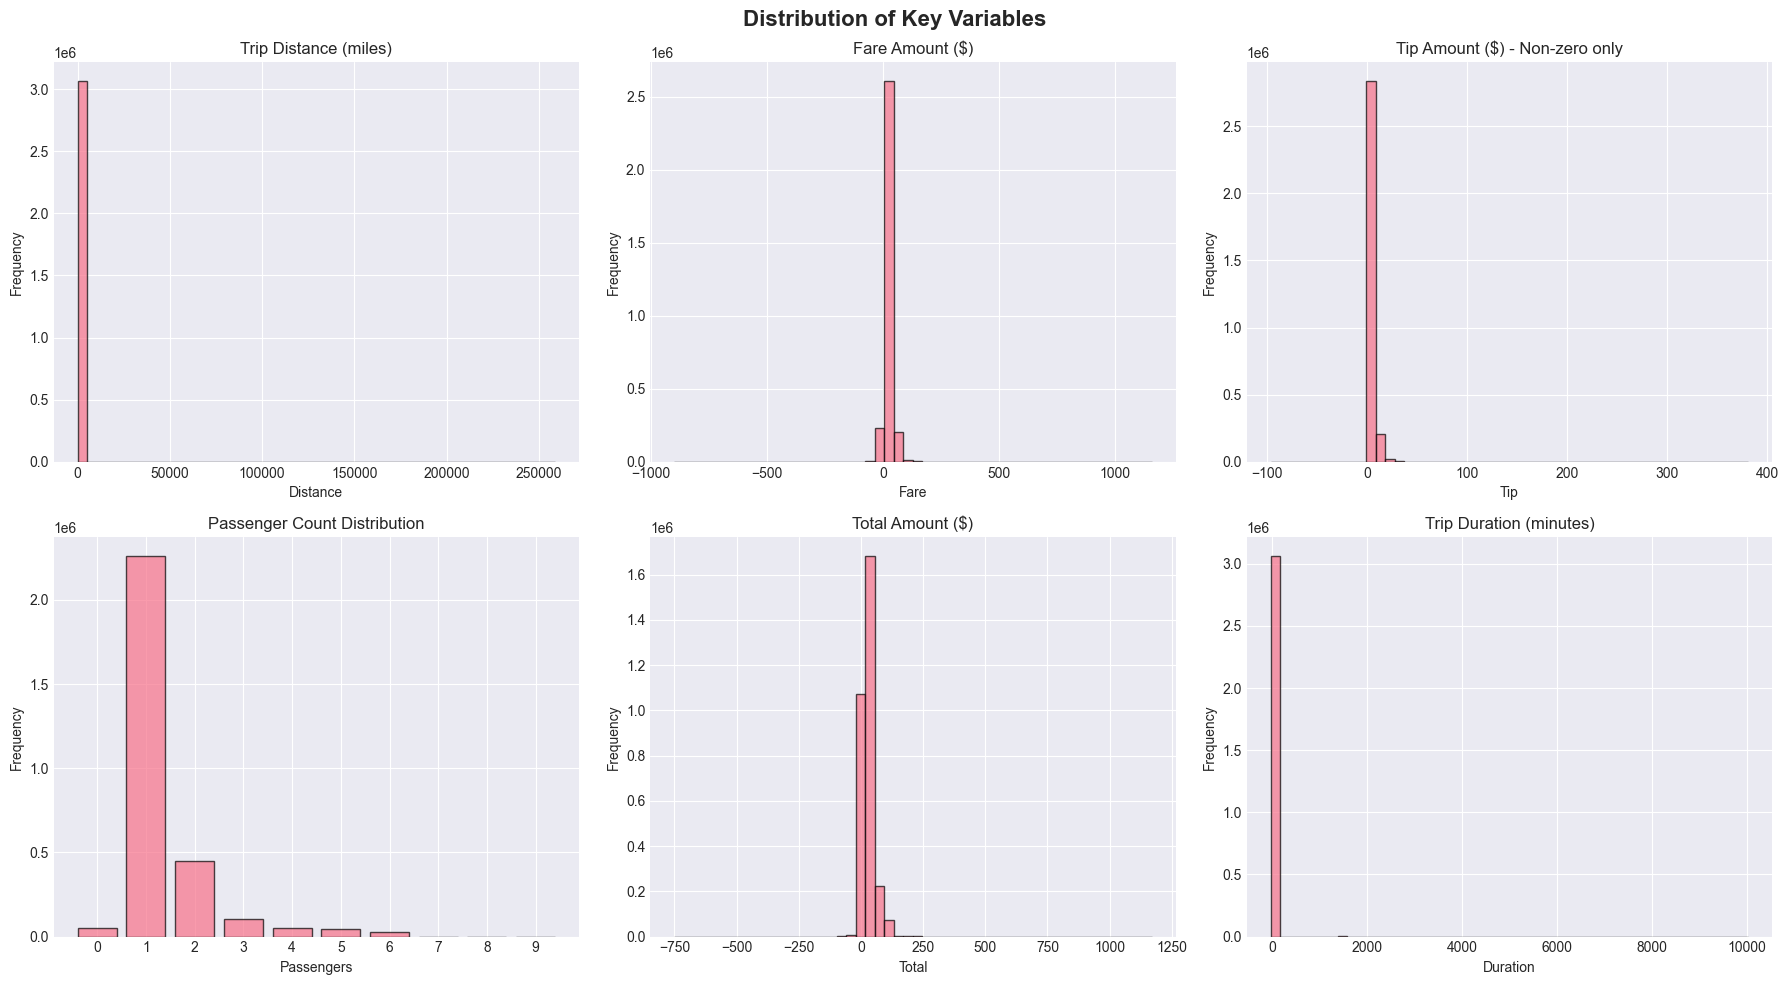

In [7]:
# Distribution of key numeric variables
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Distribution of Key Variables', fontsize=16, fontweight='bold')

# Trip distance
axes[0, 0].hist(df['trip_distance'], bins=50, edgecolor='black', alpha=0.7)
axes[0, 0].set_title('Trip Distance (miles)')
axes[0, 0].set_xlabel('Distance')
axes[0, 0].set_ylabel('Frequency')

# Fare amount
axes[0, 1].hist(df['fare_amount'], bins=50, edgecolor='black', alpha=0.7)
axes[0, 1].set_title('Fare Amount ($)')
axes[0, 1].set_xlabel('Fare')
axes[0, 1].set_ylabel('Frequency')

# Tip amount (excluding zeros)
tips_nonzero = df['tip_amount'].dropna()
axes[0, 2].hist(tips_nonzero, bins=50, edgecolor='black', alpha=0.7)
axes[0, 2].set_title('Tip Amount ($) - Non-zero only')
axes[0, 2].set_xlabel('Tip')
axes[0, 2].set_ylabel('Frequency')

# Passenger count
passenger_counts = df['passenger_count'].value_counts().sort_index()
axes[1, 0].bar(passenger_counts.index, passenger_counts.values, edgecolor='black', alpha=0.7)
axes[1, 0].set_title('Passenger Count Distribution')
axes[1, 0].set_xlabel('Passengers')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_xticks(passenger_counts.index)

# Total amount
axes[1, 1].hist(df['total_amount'], bins=50, edgecolor='black', alpha=0.7)
axes[1, 1].set_title('Total Amount ($)')
axes[1, 1].set_xlabel('Total')
axes[1, 1].set_ylabel('Frequency')

# Trip duration (calculate from datetime columns)
df['trip_duration'] = (df['dropoff_datetime'] - df['pickup_datetime']).dt.total_seconds() / 60  # minutes
axes[1, 2].hist(df['trip_duration'], bins=50, edgecolor='black', alpha=0.7)
axes[1, 2].set_title('Trip Duration (minutes)')
axes[1, 2].set_xlabel('Duration')
axes[1, 2].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

**What to look for in these distributions:**

- **Trip distance:** Likely right-skewed (many short trips, few very long ones)
- **Fare amount:** Should correlate with distance; watch for negative or zero fares
- **Tip amount:** Many zeros (no tip), then a distribution of tip amounts
- **Passenger count:** Discrete values (1-6 typically); check for unrealistic values
- **Total amount:** Should be sum of fare + tip + taxes; verify consistency
- **Trip duration:** Right-skewed; very long durations may be errors

**Key observations:**

- Most distributions will be right-skewed (common in real-world data)
- Extreme values in the tails may be outliers or errors
- Bimodal patterns might indicate different trip types (e.g., airport vs local)

### Step 2: Trends Over Time

Time series analysis is a required component of this project. Let's examine how trip volume changes over time to identify patterns, seasonality, and anomalies.

**Why temporal patterns matter:**

- **Daily patterns:** Rush hours, lunch breaks, late night
- **Weekly patterns:** Weekday vs weekend differences
- **Monthly patterns:** Seasonal effects, holidays
- **Anomalies:** Unusual days (events, weather, holidays)

Let's aggregate trips by date and visualize the trend:

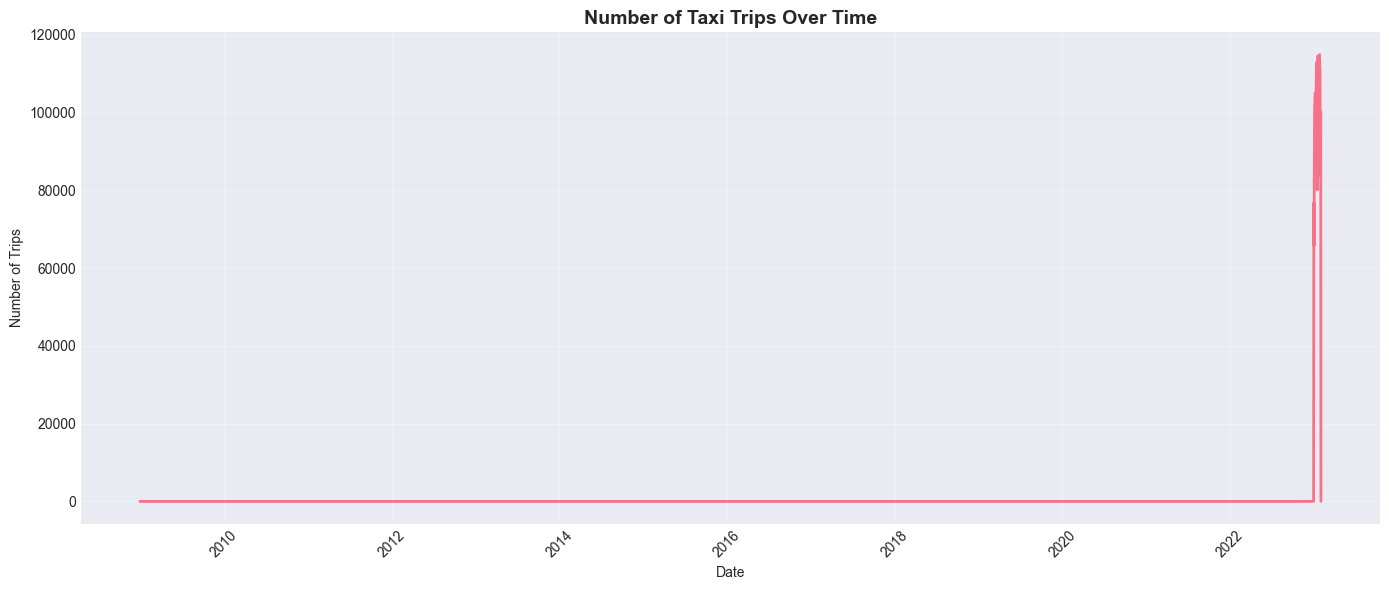


### 📅 Trip Volume Summary

| Metric | Value |
|--------|-------|
| **Average trips/day** | 85,188 |
| **Peak day** | 2023-01-26 |
| **Peak volume** | 114,877 trips |


In [8]:
# Plot trips over time to see temporal patterns
df['pickup_date'] = pd.to_datetime(df['pickup_datetime']).dt.date
trips_by_date = df.groupby('pickup_date').size()

plt.figure(figsize=(14, 6))
plt.plot(trips_by_date.index, trips_by_date.values, linewidth=2)
plt.title('Number of Taxi Trips Over Time', fontsize=14, fontweight='bold')
plt.xlabel('Date')
plt.ylabel('Number of Trips')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

display(Markdown(f"""
### 📅 Trip Volume Summary

| Metric | Value |
|--------|-------|
| **Average trips/day** | {trips_by_date.mean():,.0f} |
| **Peak day** | {trips_by_date.idxmax()} |
| **Peak volume** | {trips_by_date.max():,} trips |
"""))

**Interpreting the time series plot:**

- **Trend:** Is trip volume increasing, decreasing, or stable?
- **Weekly pattern:** Look for regular dips (weekends typically have fewer trips)
- **Outliers:** Days with unusually high or low trip counts (holidays, events, data issues)
- **Variability:** How much does daily volume fluctuate?

**Common patterns in taxi data:**

- Lower volume on weekends
- Higher volume during rush hours
- Holiday effects (New Year's Eve, Thanksgiving)
- Weather impacts (snow, rain increase demand)

### Step 3: Relationships Between Variables

Understanding relationships between variables helps us identify which features might be useful for modeling and which might be redundant (highly correlated).

**Why correlation matters:**

- **Feature selection:** Highly correlated features may be redundant
- **Model assumptions:** Some models assume independence
- **Business insights:** Understanding what drives fares, tips, etc.

Let's start with a scatter plot to visualize the relationship between distance and fare:

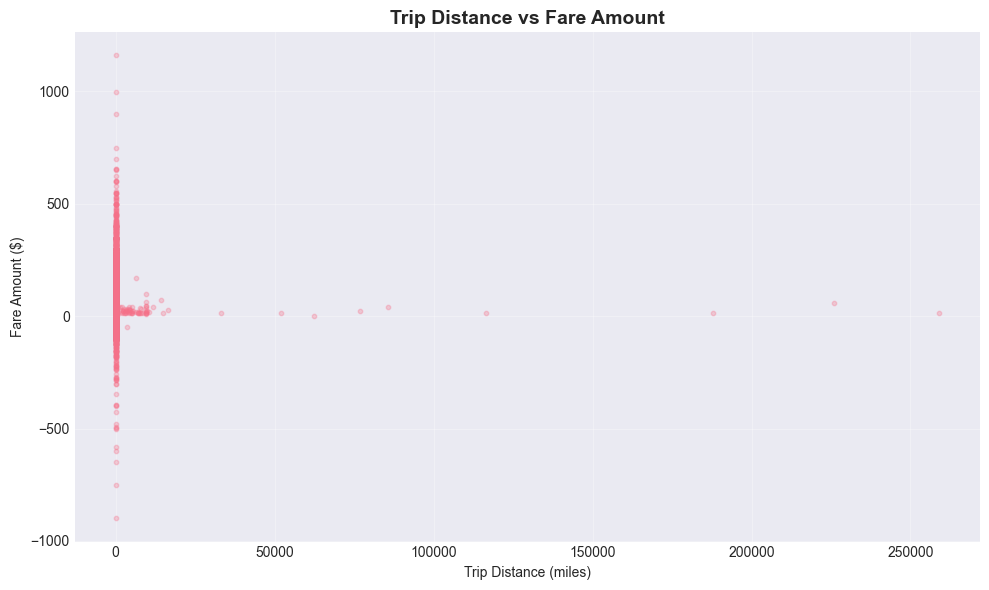

In [9]:
# Scatter plot: Distance vs Fare
plt.figure(figsize=(10, 6))
plt.scatter(df['trip_distance'], df['fare_amount'], alpha=0.3, s=10)
plt.xlabel('Trip Distance (miles)')
plt.ylabel('Fare Amount ($)')
plt.title('Trip Distance vs Fare Amount', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

**What to observe in the scatter plot:**

- **Positive relationship:** Longer trips should cost more (expected)
- **Linear vs non-linear:** Is the relationship linear or curved?
- **Outliers:** Points far from the main cluster (e.g., very short trips with high fares, or very long trips with low fares)
- **Clusters:** Multiple groups might indicate different fare structures (e.g., airport flat rates)

**Expected patterns:**

- Strong positive correlation (longer trips = higher fares)
- Some variation due to traffic, time of day, tolls
- Outliers might be data errors or special fare types

Now let's compute a correlation matrix to quantify relationships between all numeric variables:

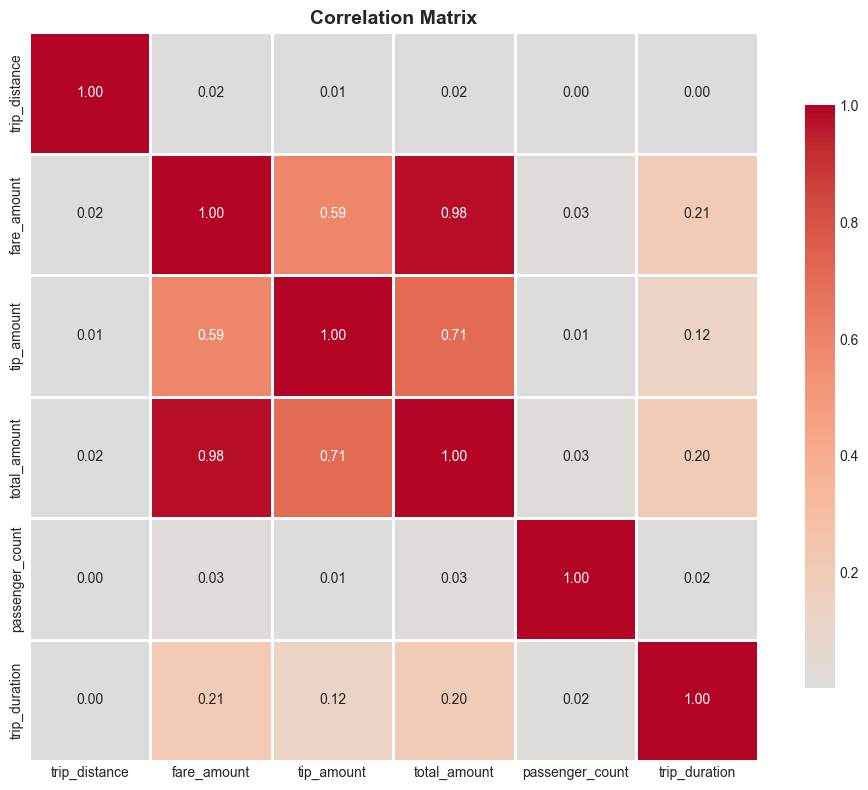

In [10]:
# Correlation matrix
numeric_cols = ['trip_distance', 'fare_amount', 'tip_amount', 'total_amount', 'passenger_count', 'trip_duration']
corr_matrix = df[numeric_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0,
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Correlation Matrix', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

**Interpreting correlation values:**

- **|r| > 0.7:** Strong correlation (may indicate redundancy)
- **0.3 < |r| < 0.7:** Moderate correlation (useful relationships)
- **|r| < 0.3:** Weak correlation (little relationship)
- **Positive values:** Variables increase together
- **Negative values:** Variables move in opposite directions

**Expected correlations:**

- `trip_distance` ↔ `fare_amount`: Strong positive (longer trips cost more)
- `fare_amount` ↔ `total_amount`: Very strong positive (fare is major component)
- `trip_distance` ↔ `trip_duration`: Moderate positive (longer trips take more time, but traffic matters)
- `tip_amount` ↔ `fare_amount`: Moderate positive (higher fares often get higher tips)

---

## Phase 3: Data Cleaning & Preprocessing

### Learning Objectives

- Identify and handle missing data
- Detect and handle outliers
- Validate data ranges
- Clean data systematically

### Step 1: Missing Data Analysis

Before handling missing data, we need to understand the extent and pattern of missingness. This informs our strategy for dealing with it.

**Why missing data analysis matters:**

- **Extent:** How much data is missing? (affects our sample size)
- **Pattern:** Is missingness random or systematic? (affects imputation strategy)
- **Impact:** Which variables are affected? (affects which features we can use)

Let's create a comprehensive missing data report:

In [11]:
display(Markdown("# 🔍 Missing Data Analysis"))

# Detailed missing data analysis with data types for context
missing_analysis = pd.DataFrame({
    'Column': df.columns,
    'Type': df.dtypes.astype(str).values,
    'Missing': df.isnull().sum().values,
    'Missing %': (df.isnull().sum() / len(df) * 100).round(2).values
})
missing_analysis = missing_analysis[missing_analysis['Missing'] > 0].sort_values('Missing', ascending=False)

if len(missing_analysis) == 0:
    display(Markdown("✅ **No missing values found!**"))
else:
    display(Markdown(missing_analysis.to_markdown(index=False)))

# 🔍 Missing Data Analysis

| Column               | Type    |   Missing |   Missing % |
|:---------------------|:--------|----------:|------------:|
| passenger_count      | float64 |     71743 |        2.34 |
| RatecodeID           | float64 |     71743 |        2.34 |
| store_and_fwd_flag   | object  |     71743 |        2.34 |
| congestion_surcharge | float64 |     71743 |        2.34 |
| airport_fee          | float64 |     71743 |        2.34 |

**Interpreting missing data:**

- **High percentage (>20%):** Consider dropping the column or using advanced imputation
- **Medium percentage (5-20%):** Can use imputation, but be cautious
- **Low percentage (<5%):** Usually safe to impute or drop rows
- **Systematic missingness:** All missing on weekends? All missing for certain trip types?

Now let's visualize the missing data pattern:

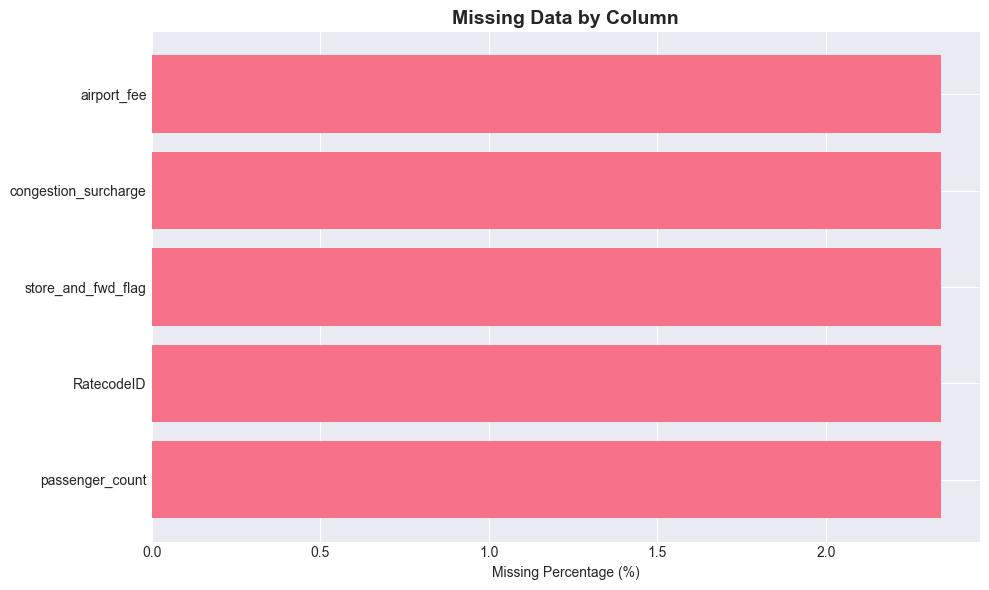

In [12]:
# Visualize missing data pattern
if len(missing_analysis) > 0:
    plt.figure(figsize=(10, 6))
    plt.barh(missing_analysis['Column'], missing_analysis['Missing %'])
    plt.xlabel('Missing Percentage (%)')
    plt.title('Missing Data by Column', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

**Visual insights:**

- Which columns have the most missing data?
- Are there patterns (e.g., all optional fields missing together)?
- Does missingness correlate with other variables?

### Step 2: Handle Missing Data

Now that we understand the missing data, we need to decide on a strategy. The approach depends on:

- **Type of variable:** Categorical vs numeric
- **Amount missing:** High vs low percentage
- **Domain knowledge:** Is missing meaningful? (e.g., missing tip = no tip)

**Common strategies:**

- **Drop rows:** If missing is rare and random
- **Drop columns:** If too much is missing
- **Impute with 0:** For counts/amounts where 0 is meaningful
- **Impute with median/mean:** For numeric variables
- **Impute with mode:** For categorical variables
- **Advanced imputation:** KNN, regression-based, etc.

For this dataset, let's handle tip_amount specifically:

In [13]:
# Strategy for handling missing data
# For tip_amount: Missing likely means no tip (0), but we'll be conservative
# and use median imputation for now

display(Markdown("## 🛠️ Handling Missing Data"))
display(Markdown(f"**Missing `tip_amount` before:** {df['tip_amount'].isnull().sum():,}"))

## 🛠️ Handling Missing Data

**Missing `tip_amount` before:** 0

**Decision point:** For `tip_amount`, we have two reasonable options:

1. **Fill with 0:** Assumes missing = no tip (common in taxi data)
2. **Fill with median:** More conservative, preserves distribution

We'll use median imputation to be conservative, but in practice, you might choose 0 based on domain knowledge:

In [14]:
# Option 1: Fill with 0 (assuming missing = no tip)
# df['tip_amount'] = df['tip_amount'].fillna(0)

# Option 2: Fill with median (more conservative)
df['tip_amount'] = df['tip_amount'].fillna(df['tip_amount'].median())

display(Markdown(f"**Missing `tip_amount` after:** {df['tip_amount'].isnull().sum()}"))

**Missing `tip_amount` after:** 0

**Note:** After imputing tip_amount, we should recalculate total_amount to ensure consistency:

In [15]:
# NYC taxi fare components (as of 2023)
MTA_TAX = 0.50  # Standard MTA state tax per trip

# Recalculate total_amount to ensure consistency after imputation
df['total_amount'] = df['fare_amount'] + df['tip_amount'] + MTA_TAX

display(Markdown("✅ **Missing data handling complete!**"))

✅ **Missing data handling complete!**

**Why recalculate?** If we imputed tip_amount, the total_amount might have been calculated before imputation, so we need to update it. The `MTA_TAX` constant makes it clear what the `0.5` represents - this is domain knowledge from NYC taxi regulations.

### Step 3: Outlier Detection

Outliers can significantly impact models and analysis. We need to identify them using statistical methods, then decide whether they're errors (remove) or valid extreme values (keep or transform).

**Why detect outliers:**

- **Model impact:** Outliers can heavily influence regression models
- **Data quality:** Extreme values may be data entry errors
- **Domain knowledge:** Some outliers are valid (e.g., very long airport trips)

**Common methods:**

- **IQR method:** Uses quartiles (robust to outliers)
- **Z-score method:** Uses standard deviations (assumes normal distribution)
- **Domain-based:** Use business rules (e.g., trips > 50 miles are errors)

Let's use the IQR (Interquartile Range) method, which is robust and doesn't assume normality:

In [16]:
display(Markdown("# 🎯 Outlier Detection"))

# Identify outliers using IQR method with Tukey fences
def detect_outliers_iqr(df, column, iqr_multiplier=1.5):
    """
    Detect outliers using the IQR (Interquartile Range) method.

    This is the Tukey fence method, which is robust and doesn't assume
    normal distribution. It's widely used in exploratory data analysis.

    Parameters:
    -----------
    df : DataFrame
        The data
    column : str
        Column name to check for outliers
    iqr_multiplier : float, default=1.5
        Tukey fence multiplier:
        - 1.5 = standard outlier detection (common choice)
        - 3.0 = extreme outlier detection (more conservative)

    Returns:
    --------
    tuple : (outliers DataFrame, lower_bound, upper_bound)
    """
    Q1 = df[column].quantile(0.25)  # 25th percentile
    Q3 = df[column].quantile(0.75)  # 75th percentile
    IQR = Q3 - Q1  # Interquartile range (middle 50% of data)

    # Tukey fences: standard statistical method for outlier detection
    lower_bound = Q1 - iqr_multiplier * IQR
    upper_bound = Q3 + iqr_multiplier * IQR

    # Find values outside the fences
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    return outliers, lower_bound, upper_bound

# 🎯 Outlier Detection

**How IQR works:**

- **Q1 (25th percentile):** 25% of data below this value
- **Q3 (75th percentile):** 75% of data below this value
- **IQR = Q3 - Q1:** The "middle 50%" range
- **Bounds:** Q1 - 1.5×IQR (lower) and Q3 + 1.5×IQR (upper)
- **Outliers:** Values outside these bounds

Now let's check for outliers in trip distance:

In [17]:
# Check trip_distance outliers
distance_outliers, dist_lower, dist_upper = detect_outliers_iqr(df, 'trip_distance')

display(Markdown(f"""
### 🚕 Trip Distance Outliers

| Metric | Value |
|--------|-------|
| **Lower bound** | {dist_lower:.2f} miles |
| **Upper bound** | {dist_upper:.2f} miles |
| **Number of outliers** | {len(distance_outliers):,} ({len(distance_outliers)/len(df)*100:.2f}%) |
"""))


### 🚕 Trip Distance Outliers

| Metric | Value |
|--------|-------|
| **Lower bound** | -2.35 miles |
| **Upper bound** | 6.74 miles |
| **Number of outliers** | 390,244 (12.72%) |


**Interpreting trip distance outliers:**

- **Negative values:** Data errors (must remove)
- **Very high values (>50 miles):** Unusual for NYC, might be airport trips or errors
- **Zero values:** Data errors (trip must have distance)

Next, let's check fare amount:

In [18]:
# Check fare_amount outliers
fare_outliers, fare_lower, fare_upper = detect_outliers_iqr(df, 'fare_amount')

display(Markdown(f"""
### 💵 Fare Amount Outliers

| Metric | Value |
|--------|-------|
| **Lower bound** | ${fare_lower:.2f} |
| **Upper bound** | ${fare_upper:.2f} |
| **Number of outliers** | {len(fare_outliers):,} ({len(fare_outliers)/len(df)*100:.2f}%) |
"""))


### 💵 Fare Amount Outliers

| Metric | Value |
|--------|-------|
| **Lower bound** | $-9.25 |
| **Upper bound** | $38.35 |
| **Number of outliers** | 325,228 (10.60%) |


**Interpreting fare outliers:**

- **Negative fares:** Data errors (must remove)
- **Zero fares:** Could be errors or promotional rides
- **Very high fares:** Might be valid (long trips, tolls, surcharges) or errors

Finally, let's check trip duration:

In [19]:
# Check trip_duration outliers (unrealistic trips)
duration_outliers, dur_lower, dur_upper = detect_outliers_iqr(df, 'trip_duration')

display(Markdown(f"""
### ⏱️ Trip Duration Outliers

| Metric | Value |
|--------|-------|
| **Lower bound** | {dur_lower:.2f} minutes |
| **Upper bound** | {dur_upper:.2f} minutes |
| **Number of outliers** | {len(duration_outliers):,} ({len(duration_outliers)/len(df)*100:.2f}%) |
"""))


### ⏱️ Trip Duration Outliers

| Metric | Value |
|--------|-------|
| **Lower bound** | -9.66 minutes |
| **Upper bound** | 35.08 minutes |
| **Number of outliers** | 170,615 (5.56%) |


**Interpreting duration outliers:**

- **Negative duration:** Data errors (dropoff before pickup - must remove)
- **Very short (<1 minute):** Might be errors or very short trips
- **Very long (>2 hours):** Unusual for NYC taxis, might be errors or special cases

### Step 4: Check for Duplicates

Duplicate records can occur due to data collection errors, system glitches, or legitimate re-submissions. We need to identify and handle them.

**Types of duplicates:**

- **Exact duplicates:** Identical rows (likely data errors)
- **Near-duplicates:** Same trip recorded multiple times (same location/time)

**Why remove duplicates:**

- **Model bias:** Duplicates give extra weight to certain observations
- **Data quality:** Indicates potential data collection issues
- **Memory/performance:** Reduces dataset size

Let's first check for completely identical rows:

In [20]:
# Check for duplicate rows
display(Markdown("# 🔄 Duplicate Detection"))

# Check for completely duplicate rows
n_duplicates = df.duplicated().sum()
display(Markdown(f"**Completely duplicate rows:** {n_duplicates:,}"))

# 🔄 Duplicate Detection

**Completely duplicate rows:** 0

**Interpreting exact duplicates:**

- **Zero duplicates:** Good data quality
- **Many duplicates:** May indicate data collection or processing issues
- **Few duplicates:** Might be legitimate (e.g., system retry)

Now let's check for near-duplicates - trips that have the same pickup/dropoff location and time:

In [21]:
# Check for duplicates based on key columns (same trip recorded twice)
# NYC TLC data uses location IDs (PULocationID, DOLocationID) instead of lat/long
# Note: If latitude/longitude coordinates were available, duplicate detection could be
# more robust using fuzzy matching (e.g., trips within ~100m of each other at similar times).
# For this dataset, exact matching on location IDs and timestamps is a reasonable approach.
key_cols = ['pickup_datetime', 'dropoff_datetime', 'PULocationID', 'DOLocationID']
# Only check if these columns exist
available_key_cols = [col for col in key_cols if col in df.columns]
if len(available_key_cols) >= 2:
    n_key_duplicates = df.duplicated(subset=available_key_cols).sum()
    display(Markdown(f"**Duplicate trips** (same pickup/dropoff location and time): {n_key_duplicates:,}"))
else:
    display(Markdown("⚠️ *Location columns not available for duplicate detection*"))

**Duplicate trips** (same pickup/dropoff location and time): 21,990

**Why check near-duplicates?**

- Same trip might be recorded multiple times due to system issues
- Location IDs are less precise than coordinates, so exact matches are reasonable
- If we had lat/long, we could use fuzzy matching (e.g., trips within 100m at similar times)

If we find duplicates, let's examine them:

In [22]:
# Show examples if any duplicates exist
if n_duplicates > 0:
    display(Markdown("### Example Duplicate Rows"))
    display(df[df.duplicated(keep=False)].head(10))

**What to look for:**

- Are duplicates truly identical, or do they differ in some columns?
- If they differ, which columns vary? (helps understand the issue)
- Should we keep the first occurrence, last, or merge them?

### Step 5: Handle Outliers

Now that we've identified outliers, we need to decide how to handle them. The strategy depends on:

- **Are they errors?** (remove them)
- **Are they valid but extreme?** (keep, cap, or transform)
- **Domain knowledge:** What makes sense for taxi trips in NYC?

**Common strategies:**

- **Remove:** If clearly errors (negative values, impossible combinations)
- **Cap:** Set extreme values to reasonable maximums
- **Transform:** Use log transformation for highly skewed data
- **Keep:** If valid extreme cases (e.g., airport trips)

Let's apply domain-specific cleaning rules:

In [23]:
# Handle outliers based on domain knowledge
display(Markdown("## 🧹 Handling Outliers"))

# Remove unrealistic trip distances (> 50 miles in NYC is very unusual)
# Or cap them at a reasonable maximum
df_clean = df.copy()
display(Markdown(f"**Original shape:** {df_clean.shape[0]:,} rows × {df_clean.shape[1]} columns"))

## 🧹 Handling Outliers

**Original shape:** 3,066,766 rows × 21 columns

**Our cleaning strategy:**

1. Remove duplicates
2. Cap extreme trip distances (NYC trips rarely exceed 50 miles)
3. Remove negative or zero distances
4. Remove unrealistic trip durations (>2 hours)
5. Remove negative fares
6. Remove unrealistic passenger counts

Let's apply these rules step by step:

In [24]:
# Remove duplicate rows (if any)
df_clean = df_clean.drop_duplicates()
display(Markdown(f"**After removing duplicates:** {df_clean.shape[0]:,} rows"))

**After removing duplicates:** 3,066,766 rows

**Why remove duplicates first?** Duplicates can inflate our counts and affect outlier detection.

In [25]:
# Define data quality thresholds based on NYC taxi domain knowledge
MAX_TRIP_DISTANCE_MILES = 50  # NYC is ~13 miles across; 50 includes airport trips
MIN_TRIP_DISTANCE = 0.01  # Must be positive (exclude zero/negative)

# Cap trip_distance at reasonable maximum
df_clean['trip_distance'] = df_clean['trip_distance'].clip(upper=MAX_TRIP_DISTANCE_MILES)

# Remove trips with negative or zero distance (data errors)
df_clean = df_clean[df_clean['trip_distance'] > MIN_TRIP_DISTANCE]

**Distance cleaning rationale:**

- **Cap at 50 miles:** Manhattan is ~13 miles long; 50 miles includes all airport trips (JFK, EWR, LGA)
- **Remove ≤ 0:** These are clear data errors (impossible trips)

In [26]:
# More domain-specific thresholds
MAX_TRIP_DURATION_MINUTES = 120  # 2 hours; longer suggests data errors or forgotten meter
MIN_FARE_AMOUNT = 0.01  # Fares must be positive
MIN_PASSENGERS = 1  # At least one passenger
MAX_PASSENGERS = 6  # Standard NYC taxi capacity

# Apply temporal constraints
df_clean = df_clean[df_clean['trip_duration'] <= MAX_TRIP_DURATION_MINUTES]

# Apply financial constraints
df_clean = df_clean[df_clean['fare_amount'] >= MIN_FARE_AMOUNT]

# Apply passenger constraints
df_clean = df_clean[df_clean['passenger_count'].between(MIN_PASSENGERS, MAX_PASSENGERS)]

**Additional cleaning rules:**

- **Duration ≤ 120 min:** Very long trips unusual in NYC; likely forgotten meter or data error
- **Fare ≥ $0.01:** Negative/zero fares are data errors (no free rides in this dataset)
- **Passengers 1-6:** Standard yellow cab capacity; outside this range = data error

Let's see the impact of our cleaning:

In [27]:
display(Markdown(f"""
### 📊 Cleaning Results

| Metric | Value |
|--------|-------|
| **Original rows** | {len(df):,} |
| **Cleaned rows** | {df_clean.shape[0]:,} |
| **Rows removed** | {len(df) - len(df_clean):,} ({(len(df) - len(df_clean))/len(df)*100:.2f}%) |
"""))


### 📊 Cleaning Results

| Metric | Value |
|--------|-------|
| **Original rows** | 3,066,766 |
| **Cleaned rows** | 2,879,404 |
| **Rows removed** | 187,362 (6.11%) |


**Interpreting the results:**

- **Removal percentage:** How much data did we lose?
- **If >10%:** Might be too aggressive, reconsider thresholds
- **If <1%:** Very clean data, or thresholds too lenient
- **Balance:** Remove errors while preserving valid extreme cases

### Step 6: Data Type Validation and Conversion

After cleaning, we need to ensure all data types are correct. This is crucial for:

- **Performance:** Correct types use less memory and process faster
- **Functionality:** Some operations require specific types (e.g., datetime operations)
- **Modeling:** Machine learning models expect numeric types

**Common type issues:**

- Datetime columns stored as strings
- Numeric columns stored as strings (e.g., "12.5" instead of 12.5)
- Categorical columns stored as numeric codes

Let's validate and convert data types:

In [28]:
# Ensure datetime columns are properly typed
display(Markdown("## 🔧 Validating and Converting Data Types"))

df_clean['pickup_datetime'] = pd.to_datetime(df_clean['pickup_datetime'])
df_clean['dropoff_datetime'] = pd.to_datetime(df_clean['dropoff_datetime'])

## 🔧 Validating and Converting Data Types

**Why datetime conversion matters:**

- Enables time-based operations (resampling, rolling windows)
- Allows extraction of temporal features (hour, day of week, month)
- Required for time series analysis

Now let's ensure numeric columns are properly typed:

In [29]:
# Ensure numeric columns are proper types
numeric_cols = ['trip_distance', 'fare_amount', 'tip_amount', 'total_amount', 
                'passenger_count', 'trip_duration']
for col in numeric_cols:
    df_clean[col] = pd.to_numeric(df_clean[col], errors='coerce')

**Why numeric conversion matters:**

- Mathematical operations require numeric types
- Models expect numeric inputs
- `errors='coerce'` converts invalid values to NaN (which we can then handle)

Let's verify everything is correct:

In [30]:
# Check for any remaining issues
display(Markdown("## ✅ Final Data Quality Check"))

# Create a clean summary of the final dataset
final_summary = pd.DataFrame({
    'Column': df_clean.columns,
    'Type': df_clean.dtypes.astype(str).values,
    'Non-Null': df_clean.notna().sum().values,
    'Null': df_clean.isnull().sum().values
})

display(Markdown(f"""
| Metric | Value |
|--------|-------|
| **Total rows** | {df_clean.shape[0]:,} |
| **Total columns** | {df_clean.shape[1]} |
| **Missing values** | {df_clean.isnull().sum().sum()} |
"""))

display(Markdown("### Column Types Summary"))
display(Markdown(final_summary.to_markdown(index=False)))

## ✅ Final Data Quality Check


| Metric | Value |
|--------|-------|
| **Total rows** | 2,879,404 |
| **Total columns** | 21 |
| **Missing values** | 0 |


### Column Types Summary

| Column                | Type           |   Non-Null |   Null |
|:----------------------|:---------------|-----------:|-------:|
| VendorID              | int64          |    2879404 |      0 |
| pickup_datetime       | datetime64[us] |    2879404 |      0 |
| dropoff_datetime      | datetime64[us] |    2879404 |      0 |
| passenger_count       | float64        |    2879404 |      0 |
| trip_distance         | float64        |    2879404 |      0 |
| RatecodeID            | float64        |    2879404 |      0 |
| store_and_fwd_flag    | object         |    2879404 |      0 |
| PULocationID          | int64          |    2879404 |      0 |
| DOLocationID          | int64          |    2879404 |      0 |
| payment_type          | int64          |    2879404 |      0 |
| fare_amount           | float64        |    2879404 |      0 |
| extra                 | float64        |    2879404 |      0 |
| mta_tax               | float64        |    2879404 |      0 |
| tip_amount            | float64        |    2879404 |      0 |
| tolls_amount          | float64        |    2879404 |      0 |
| improvement_surcharge | float64        |    2879404 |      0 |
| total_amount          | float64        |    2879404 |      0 |
| congestion_surcharge  | float64        |    2879404 |      0 |
| airport_fee           | float64        |    2879404 |      0 |
| trip_duration         | float64        |    2879404 |      0 |
| pickup_date           | object         |    2879404 |      0 |

**Final validation checklist:**

- ✅ All datetime columns are datetime type
- ✅ All numeric columns are numeric type
- ✅ Missing values are handled or acceptable
- ✅ Dataset shape is reasonable (not too much data removed)

### Step 7: Save Cleaned Data

Now that we've cleaned and validated our data, we should save it for use in the next notebook. This ensures we don't have to repeat the cleaning process.

**Why save intermediate results:**

- **Efficiency:** Avoid re-running time-consuming cleaning steps
- **Reproducibility:** Others can use the cleaned data
- **Version control:** Track data transformations
- **Backup:** In case we need to revert changes

Let's save the cleaned dataset:

In [31]:
# Save cleaned dataset for next notebook
output_dir = '../output'
import os
os.makedirs(output_dir, exist_ok=True)

df_clean.to_csv(f'{output_dir}/01_cleaned_taxi_data.csv', index=False)

display(Markdown(f"""
### 💾 Data Saved Successfully

- **File:** `{output_dir}/01_cleaned_taxi_data.csv`
- **Rows:** {len(df_clean):,}

✅ **Ready for next phase: Data Wrangling & Feature Engineering!**
"""))


### 💾 Data Saved Successfully

- **File:** `../output/01_cleaned_taxi_data.csv`
- **Rows:** 2,879,404

✅ **Ready for next phase: Data Wrangling & Feature Engineering!**


**File format considerations:**

- **CSV:** Human-readable, universal compatibility, but larger file size
- **Parquet:** Compressed, faster to read/write, preserves data types, but requires special libraries
- **Pickle:** Python-specific, preserves everything, but not portable across languages

For this project, CSV is a good choice for compatibility and ease of use.

---

## Summary

**What we accomplished:**

1. ✅ **Loaded data** and performed initial inspection
2. ✅ **Explored distributions** and relationships
3. ✅ **Identified missing data** and handled it appropriately
4. ✅ **Detected outliers** using statistical methods
5. ✅ **Cleaned data** based on domain knowledge
6. ✅ **Validated data types** and ranges
7. ✅ **Saved cleaned dataset** for next phase

**Key Takeaways:**

- Always inspect data before cleaning
- Use domain knowledge to guide cleaning decisions
- Document your cleaning steps
- Save intermediate results

**Next:** Notebook 2 will focus on data wrangling, merging, and feature engineering.